<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#clustering" data-toc-modified-id="clustering-1">clustering</a></span></li><li><span><a href="#Moyenne-mobile-des-séries" data-toc-modified-id="Moyenne-mobile-des-séries-2">Moyenne mobile des séries</a></span></li><li><span><a href="#Décomposition-des-séries" data-toc-modified-id="Décomposition-des-séries-3">Décomposition des séries</a></span></li></ul></div>

In [1]:
from IPython.display import display
from math import ceil, sqrt
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm
import joblib

from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller

# colors generator
from itertools import cycle
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.decomposition import PCA
from tslearn.barycenters import dtw_barycenter_averaging
# Modeling
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# from statsmodels.tsa.arima_model import ARIMA
# import pmdarima as pm
from sklearn.model_selection import ParameterGrid
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# assert reproducibility
import random
random.seed(7)
np.random.seed(7)
print("setup complete")

setup complete


In [2]:
sales = pd.read_csv('70prod_data.csv',\
                    index_col=0, parse_dates=True)

In [3]:
sales.head()

,P_1,P_2,P_3,P_4,P_5,P_6,P_7,P_8,P_9,P_10,...,P_61,P_62,P_63,P_64,P_65,P_66,P_67,P_68,P_69,P_70
2014-07-31,2669,3603,3506,1274,1528,2244,1460,2523,2045,1713,...,1721,2506,3011,1039,1374,1840,1359,1407,1108,1544
2014-08-31,2794,3405,3279,1449,1526,1970,1423,2660,2065,1774,...,1906,2701,3081,1134,1331,1877,1424,1503,1061,1490
2014-09-30,2289,3434,3238,1426,1484,1877,1369,2581,1775,1875,...,1979,2618,3004,1160,1327,1827,1357,1449,1049,1465
2014-10-31,2310,3277,3088,1404,1500,1615,1159,2326,1614,1893,...,1982,2693,3215,1180,1369,1883,1384,1446,1050,1584
2014-11-30,2559,3396,2921,1329,1384,1796,1395,2351,1749,1678,...,2025,2607,3280,1065,1286,1766,1345,1377,988,1518


In [4]:
sales.describe().T

,count,mean,std,min,25%,50%,75%,max
P_1,63.0,3510.761905,656.364885,2289.0,2997.0,3546.0,3992.0,4885.0
P_2,63.0,4341.333333,671.591874,3152.0,3848.0,4464.0,4810.0,5873.0
P_3,63.0,4448.523810,693.352814,2909.0,4105.5,4607.0,4943.0,5644.0
P_4,63.0,2267.888889,435.481014,1274.0,2065.0,2371.0,2541.5,2974.0
P_5,63.0,2390.111111,489.206009,1252.0,2198.5,2492.0,2705.5,3327.0
...,...,...,...,...,...,...,...,...
P_66,63.0,2075.317460,231.814082,1742.0,1877.5,2035.0,2231.0,2591.0
P_67,63.0,1685.857143,275.337556,1294.0,1424.0,1645.0,1928.5,2199.0
P_68,63.0,1649.063492,303.335058,748.0,1427.5,1562.0,1915.5,2243.0
P_69,63.0,1420.682540,313.456218,766.0,1164.0,1538.0,1658.5,1968.0


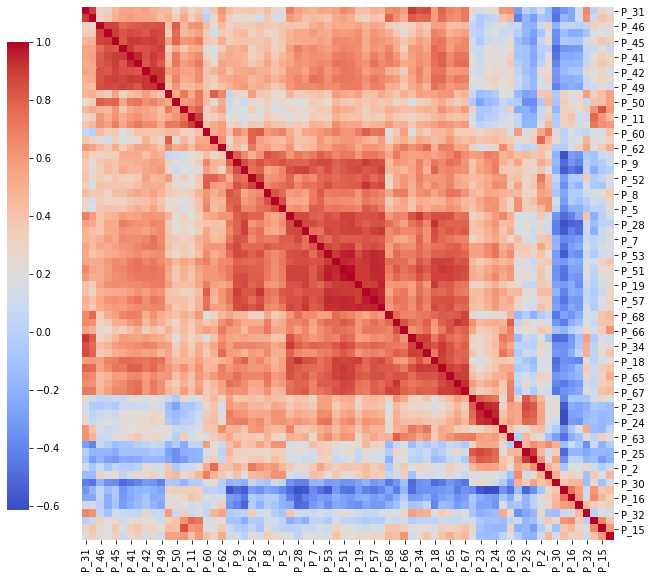

In [5]:
#ax = sns.heatmap(sales.corr())
cg = sns.clustermap(sales.corr(), figsize=(10, 10), cbar_pos=(.1, .1, .03, .65), cmap="coolwarm")
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
plt.show()

On observe une forte correlation entre certains groupes de produits, ce qui suggère qu'on peut les classifier selon leurs comportements de ventes.


## clustering
L'un des problèmes qu'on doit traiter avant de commencer le partitionnement (clustering) est l'échelle de la série. Sans normaliser les données, les séries qui se ressemblent seront vues si différentes les unes des autres et affecteront la précision du processus de clustering. Nous pouvons voir l'effet de la normalisation dans les images suivantes.

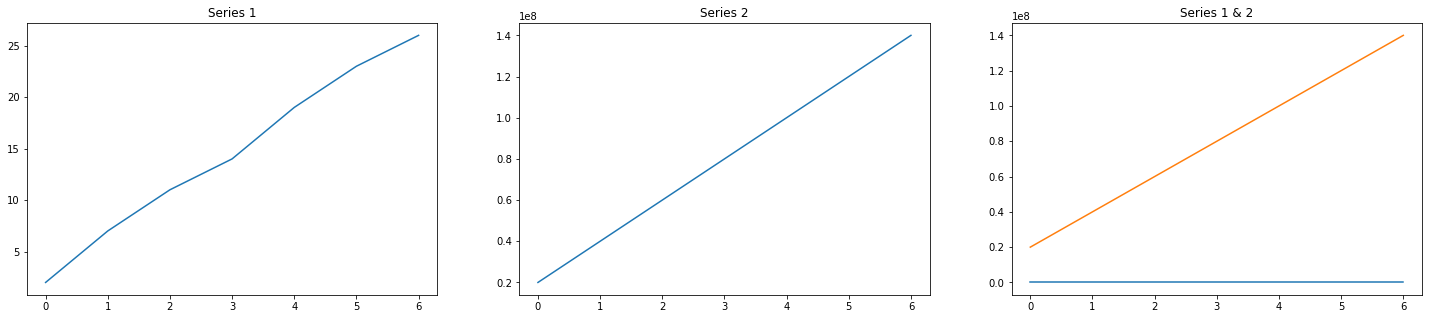

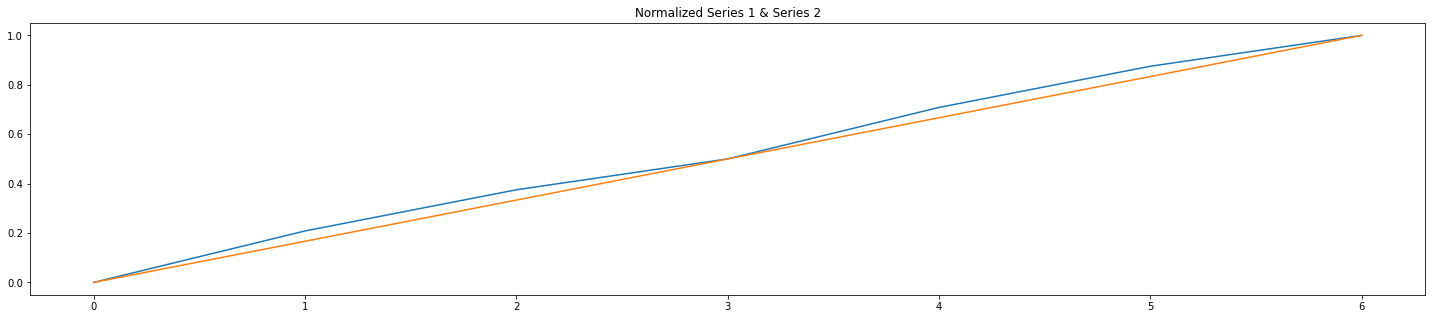

In [6]:
a = [[2],[7],[11],[14],[19],[23],[26]]
b = [[20000000],[40000000],[60000000],[80000000],[100000000],[120000000],[140000000]]
fig, axs = plt.subplots(1,3,figsize=(25,5))
axs[0].plot(a)
axs[0].set_title("Series 1")
axs[1].plot(b)
axs[1].set_title("Series 2")
axs[2].plot(a)
axs[2].plot(b)
axs[2].set_title("Series 1 & 2")
plt.figure(figsize=(25,5))
plt.plot(MinMaxScaler().fit_transform(a))
plt.plot(MinMaxScaler().fit_transform(b))
plt.title("Normalized Series 1 & Series 2")
plt.show()

In [7]:
mySeries = sales.copy()
scaler = MinMaxScaler()
mySeries = MinMaxScaler().fit_transform(mySeries).T

Afin de regrouper nos séries avec des k-moyennes, les indices temporels des séries chronologiques seront considérés comme des caractéristiques différentes et seront les dimensions des points de données(les séries). 

Puisque la longueur des série temporelles en pratique est souvent importante, un autre problème auquel on doit faire face est la malédiction de la dimensionnalité,ce terme a été inventé pour la première fois par Richard E. Bellman lors de l'examen des problèmes de programmation dynamique. Cela signifie essentiellement que lorsque la dimensionnalité des données augmente, la distance entre les points de données augmente également. Ainsi, ce changement de mesure de la distance affecte gravement les algorithmes basés sur la distance.

Pour résoudre ce problème, on va effectuer une analyse en composantes principales ACP avant le partitionnement.

In [8]:
pca = PCA(n_components=2)
pca_res = pca.fit_transform(mySeries)

Désormais avec moins de dimensions qu'avant, nous pouvons voir comment nos séries se répartissent en 2 dimensions.

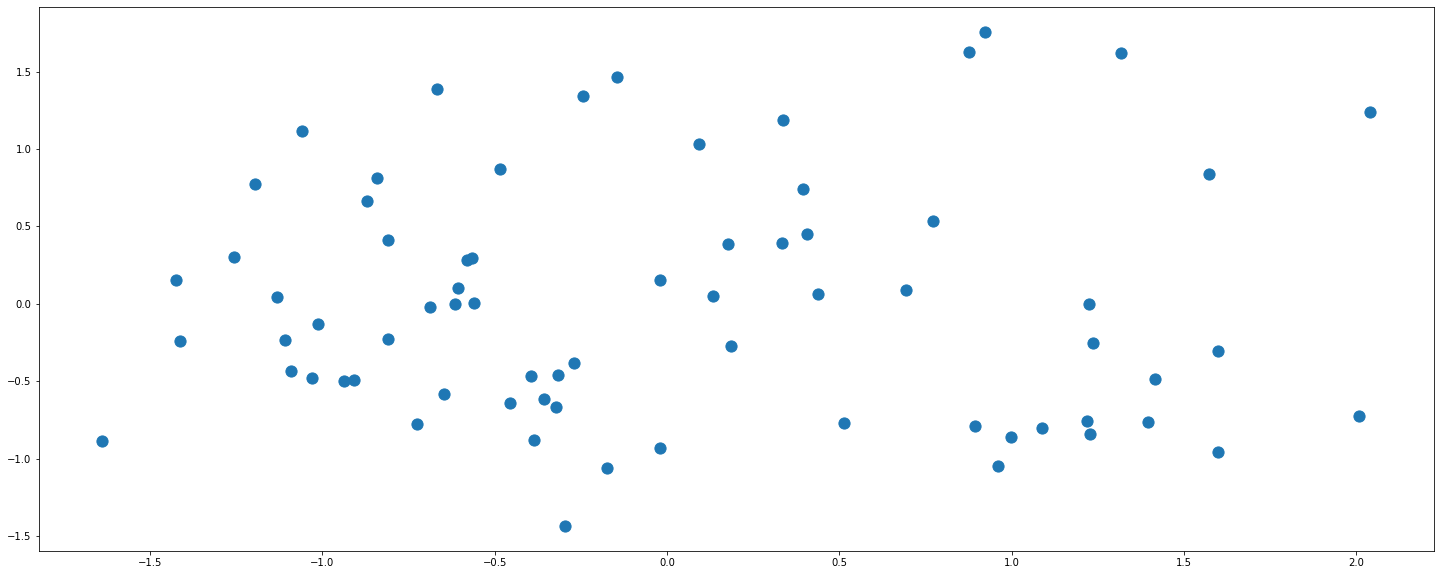

In [9]:
plt.figure(figsize=(25,10))
plt.scatter(pca_res[:,0],pca_res[:,1], s=125)
plt.show()

Kmeans:
Le partitionnement en k-moyennes (ou k-means en anglais) est une méthode de partitionnement de données et un problème d'optimisation combinatoire. Étant donnés des points et un entier k, le problème est de diviser les points en k groupes, souvent appelés clusters, de façon à minimiser une certaine fonction. On considère la distance d'un point à la moyenne des points de son cluster (centroid) ; la fonction à minimiser est la somme des carrés de ces distances,la distance euclidienne est souvent utilisée.

Initialement on va éstimer le nombre de clusters requis par la racine du nombre des points (séries), on obtient 9 clusters.

In [10]:
cluster_count = ceil(sqrt(len(mySeries))) 
cluster_count

9

et on va appliquer la méthode de Kmeans sur le résultat de l'ACP.

In [11]:
joblib_Filename = "kmeans_object.joblib"

# if compress: joblib_Filename += '.z'
try:
    kmeans = joblib.load(joblib_Filename)
except FileNotFoundError:
    print("file creation")
    kmeans = KMeans(n_clusters=cluster_count,max_iter=50000)
    kmeans.fit(pca_res)
    joblib.dump(kmeans, joblib_Filename)

labels = kmeans.predict(pca_res)


Après l'entrainement du modèle, on a présenté les résultats. Pour chaque cluster, on a tracé les séries en gris, et afin de visualiser le mouvement et le comportement des séries appartenant au même cluster, on a pris la moyenne du cluster et tracé cette série moyenne en rouge.

In [12]:
labels

array([1, 3, 7, 4, 1, 3, 4, 1, 4, 3, 2, 2, 0, 2, 6, 0, 6, 5, 8, 0, 7, 6,
       7, 7, 7, 3, 7, 4, 4, 0, 1, 6, 4, 8, 8, 6, 5, 1, 8, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 8, 1, 4, 4, 4, 1, 4, 8, 8, 6, 8, 6, 6, 8, 5, 6,
       5, 1, 4, 6])

In [13]:
clusters = [[] for _ in range(cluster_count)]
for i, lab in enumerate(labels):
    clusters[lab].append(i)
clusters

[[12, 15, 19, 29, 39],
 [0, 4, 7, 30, 37, 51, 55, 67],
 [10, 11, 13, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
 [1, 5, 9, 25],
 [3, 6, 8, 27, 28, 32, 52, 53, 54, 56, 68],
 [17, 36, 64, 66],
 [14, 16, 21, 31, 35, 59, 61, 62, 65, 69],
 [2, 20, 22, 23, 24, 26],
 [18, 33, 34, 38, 50, 57, 58, 60, 63]]

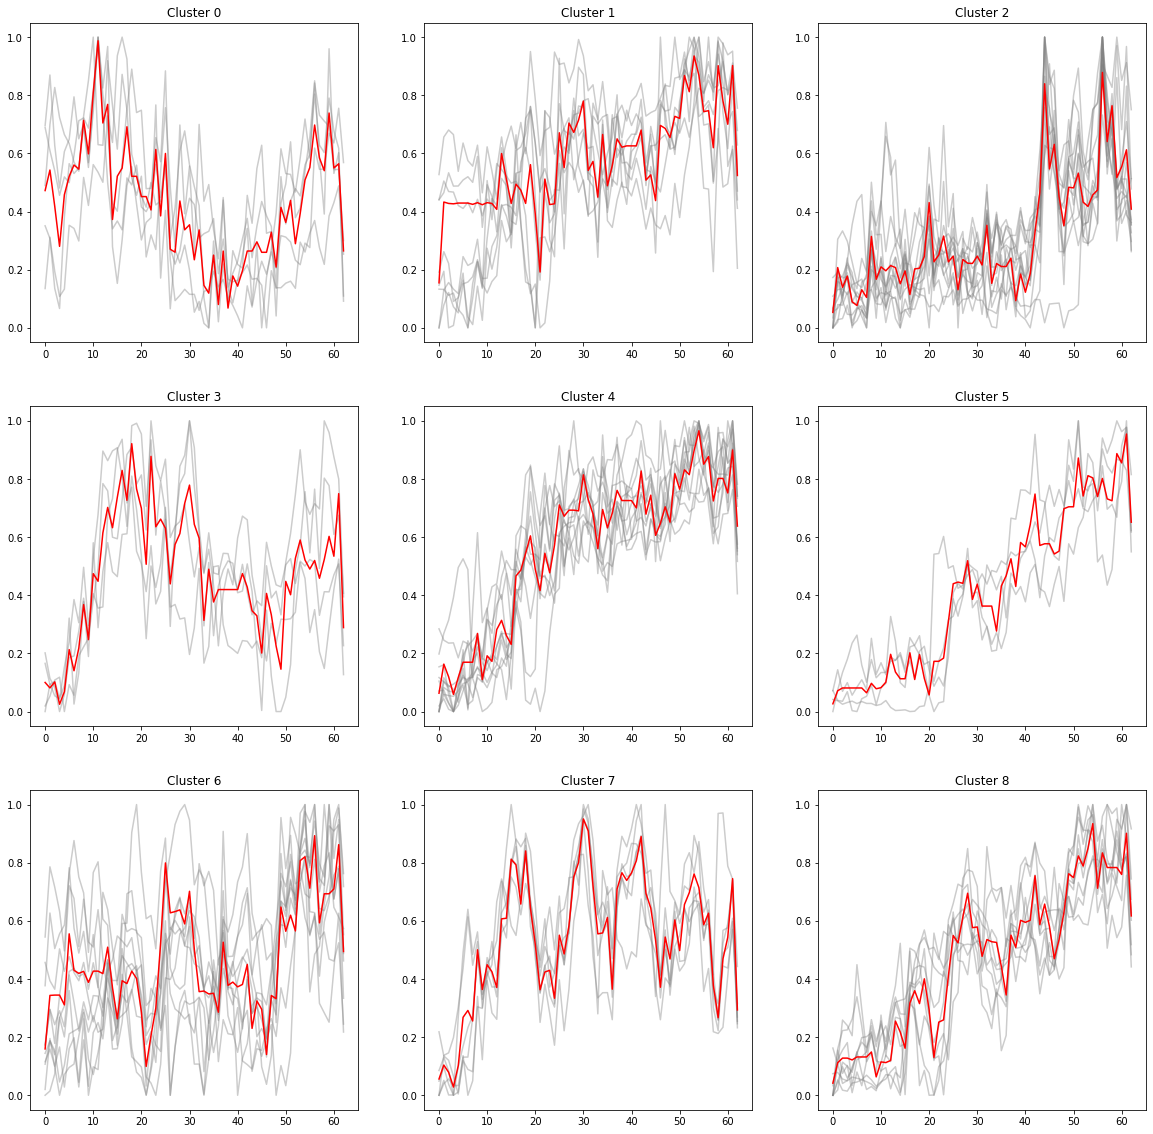

In [14]:
plot_count = ceil(sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(20,20))
axs = axs.flatten()
for i, cluster in enumerate(clusters):
    pd.DataFrame(mySeries).T.iloc[:,cluster].plot(ax=axs[i],c="gray",alpha=0.4,legend=False)
    if len(cluster) > 0:
        axs[i].plot(dtw_barycenter_averaging(pd.DataFrame(mySeries).iloc[cluster]),c="red")
    axs[i].set_title("Cluster "+str(i))
plt.show()

Nous pouvons voir la distribution des séries chronologiques en clusters dans le graphique suivant.

les séries semblent uniformement distribuées aux clusters.

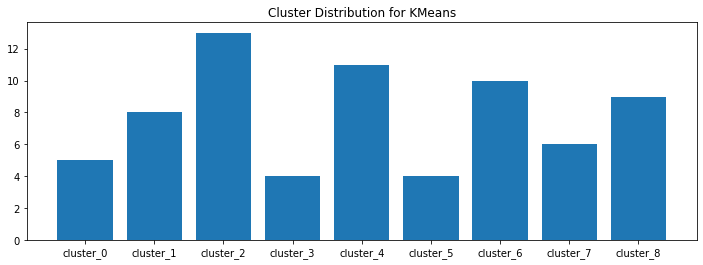

In [15]:
clusters_c = list(map(len, clusters))
clusters_n = ["cluster_"+str(i) for i in range(cluster_count)]
plt.figure(figsize=(12,4))
plt.title("Cluster Distribution for KMeans")
plt.bar(clusters_n,clusters_c)
plt.show()

Pour bénéficier de partitionnement qu'on a fait, il est nécessaire de lister pour chaque cluster, les séries qui lui appartiennent.

In [16]:
for cluster, cluster_n in zip(clusters, clusters_n):
#     print(cluster_n, ':', [sales.columns[p] for p in cluster])
    print(cluster_n+':', ', '.join(['P_'+str(p) for p in cluster]))

cluster_0: P_12, P_15, P_19, P_29, P_39
cluster_1: P_0, P_4, P_7, P_30, P_37, P_51, P_55, P_67
cluster_2: P_10, P_11, P_13, P_40, P_41, P_42, P_43, P_44, P_45, P_46, P_47, P_48, P_49
cluster_3: P_1, P_5, P_9, P_25
cluster_4: P_3, P_6, P_8, P_27, P_28, P_32, P_52, P_53, P_54, P_56, P_68
cluster_5: P_17, P_36, P_64, P_66
cluster_6: P_14, P_16, P_21, P_31, P_35, P_59, P_61, P_62, P_65, P_69
cluster_7: P_2, P_20, P_22, P_23, P_24, P_26
cluster_8: P_18, P_33, P_34, P_38, P_50, P_57, P_58, P_60, P_63


In [17]:
viz=sales.loc[:,['P_9','P_25','P_18','P_13']]

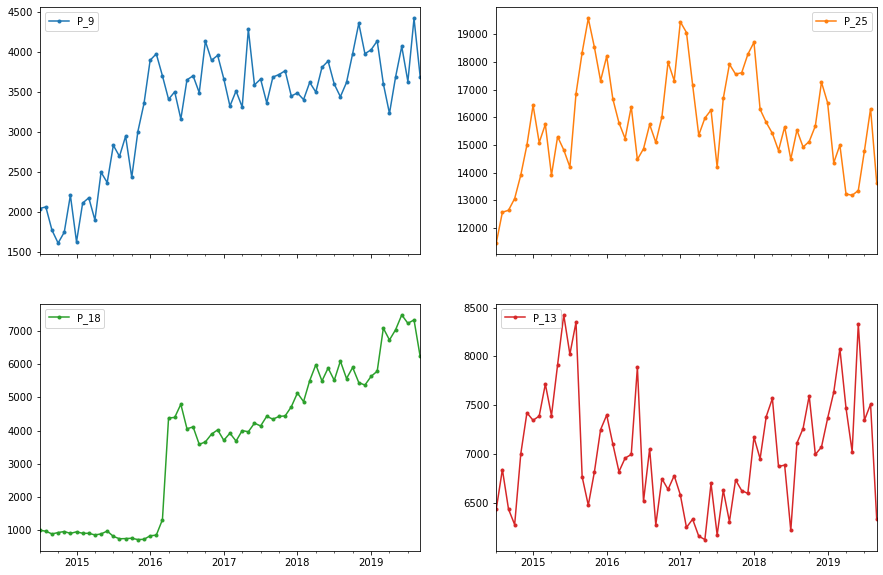

In [18]:
viz.plot(subplots=True,layout=(2,2),figsize=(15,10), marker='.')
plt.show()

On a selectionné le produit le plus proche du centroide de chaque cluster, autrement dit le plus proche aux autres produits au même groupe.

In [19]:
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, pca_res)
closest

array([29, 37, 46,  1, 54, 36, 21, 20, 63], dtype=int64)

Pour visualiser ce résultat, on a tracé l'ensemble des points ainsi que les centres des groupes (étoiles), le point le plus proche de chaque centre est présenté en gris.

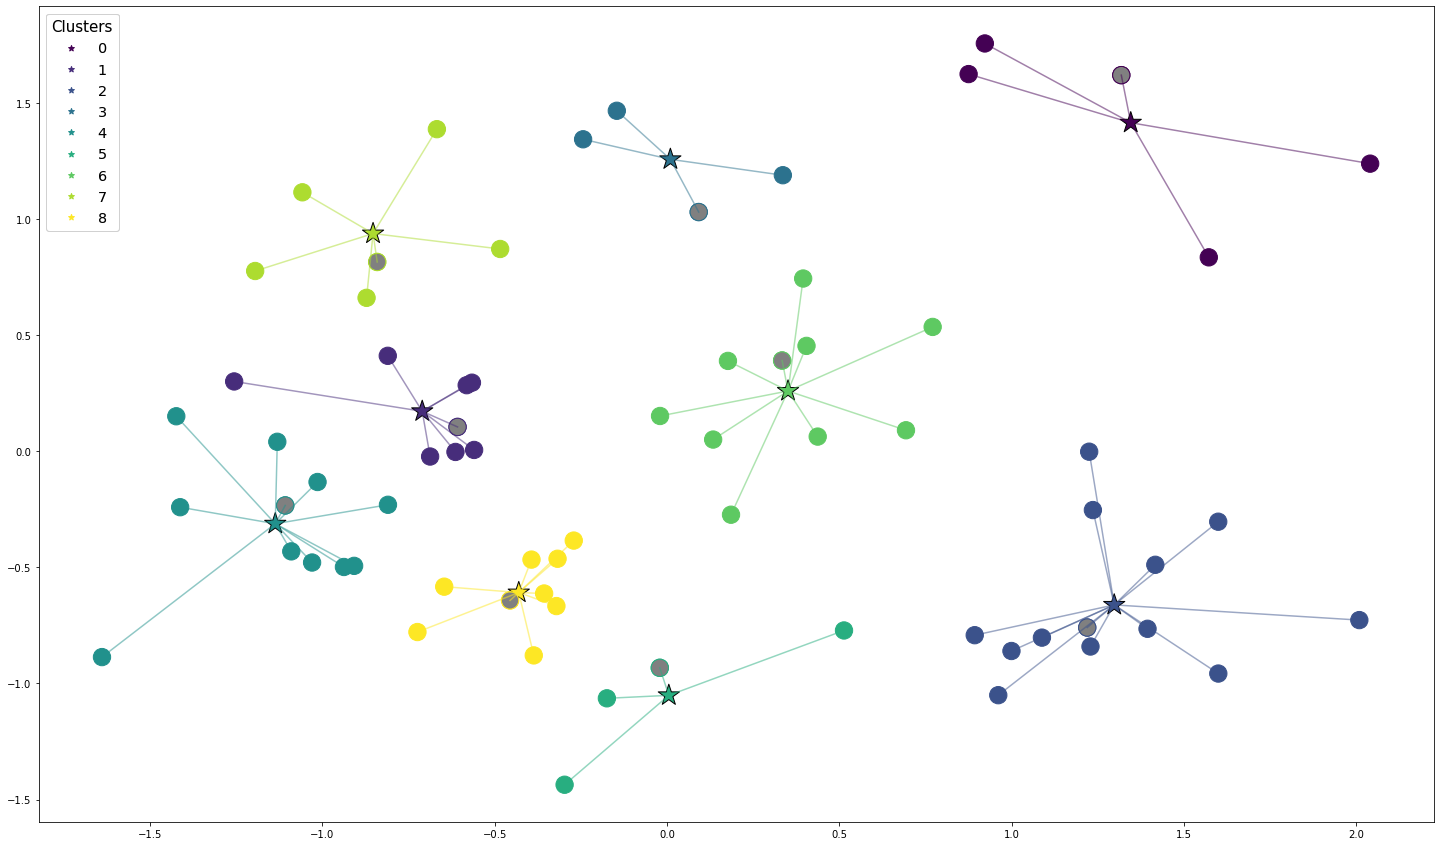

In [20]:
fig, ax = plt.subplots(figsize=(25,15))
ax.scatter(pca_res[:, 0], pca_res[:, 1], c=labels, s=300)
sc = ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], \
            marker='*', c=np.unique(labels), edgecolors='black', s=500, label=np.unique(labels))
legend1 = ax.legend(*sc.legend_elements(), 
                    loc="upper left", title="Clusters", fontsize="x-large")
legend1.get_title().set_fontsize('15')
ax.add_artist(legend1)

ax.scatter(pca_res[closest, 0], pca_res[closest, 1], c='grey', \
            edgecolors=[sc.to_rgba(lab) for lab in np.unique(labels)], s=300)

for cluster_lab, cluster_x, cluster_y in \
zip(np.unique(labels), kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1]):
    for pt_lab, pt_x, pt_y in zip(labels, pca_res[:, 0], pca_res[:, 1]):
        if cluster_lab==pt_lab:
            x, y = [cluster_x, pt_x], [cluster_y, pt_y]
            ax.plot(x, y, c=sc.to_rgba(cluster_lab), alpha=0.5)

pour re vérifier ces résultats, on peut voir que les séries choisis sont centrées pour chaque groupe. 

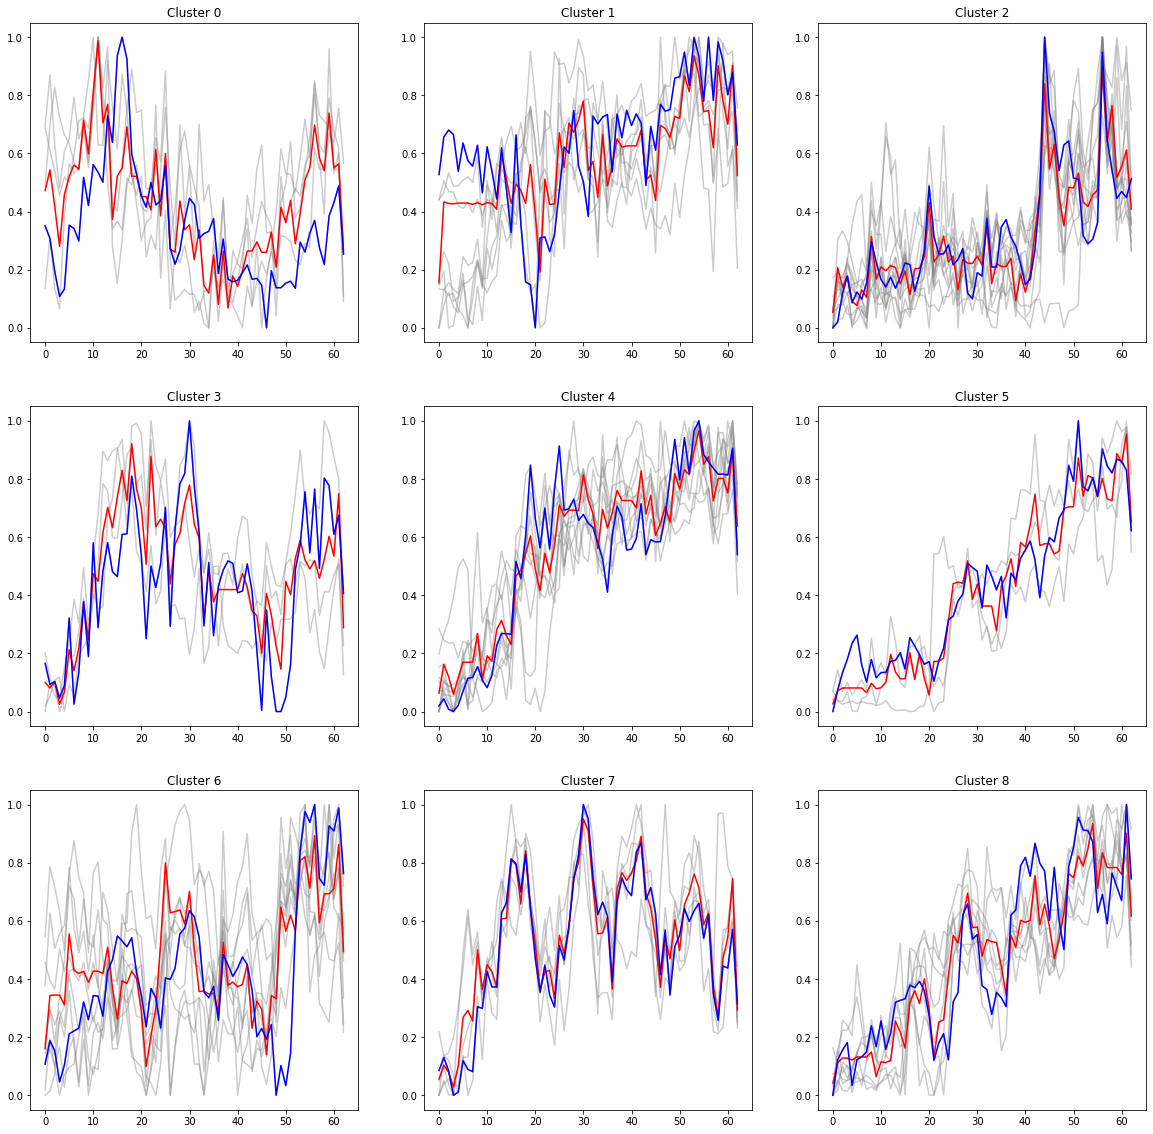

In [21]:
fig, axs = plt.subplots(plot_count,plot_count,figsize=(20,20))
axs = axs.flatten()
for i, cluster in enumerate(clusters):
    pd.DataFrame(mySeries).T.iloc[:,cluster].plot(ax=axs[i],c="gray",alpha=0.4,legend=False)
    if len(cluster) > 0:
        axs[i].plot(dtw_barycenter_averaging(pd.DataFrame(mySeries).iloc[cluster]),c="red")
        pd.DataFrame(mySeries).T.iloc[:,[p for p in cluster if p in closest]].plot(ax=axs[i],c="blue", legend=False)

    axs[i].set_title("Cluster "+str(i))
plt.show()

On a extrait les produits représentatifs des groupes et on a construit un nouveau jeu de données de séries temporelles sur lequel on va travailler par la suite.

In [185]:
sales_s = sales.iloc[:, sorted(closest)]
sales_s.head()

,P_2,P_21,P_22,P_30,P_37,P_38,P_47,P_55,P_64
2014-07-31,3603,16302,10467,19852,1865,3510,510,3849,1039
2014-08-31,3405,16907,11319,19164,2043,3804,524,3980,1134
2014-09-30,3434,16286,10956,17382,2188,3859,595,3787,1160
2014-10-31,3277,15147,9822,16034,2297,3823,636,3745,1180
2014-11-30,3396,15298,10427,16430,2432,3535,572,3861,1065


,count,mean,std,min,25%,50%,75%,max
P_2,63.0,4341.3,671.6,3152.0,3848.0,4464.0,4810.0,5873.0
P_21,63.0,22139.8,3253.3,15147.0,19920.0,22859.0,24254.5,28709.0
P_22,63.0,13833.5,2646.6,9339.0,11800.0,13541.0,15096.5,19889.0
P_30,63.0,19873.6,3179.0,14339.0,17350.5,19426.0,21268.5,30048.0
P_37,63.0,2912.9,635.7,1865.0,2296.5,2873.0,3335.5,4273.0
P_38,63.0,3731.3,485.3,2310.0,3481.0,3797.0,4012.5,4586.0
P_47,63.0,735.2,147.9,510.0,633.5,698.0,828.0,1222.0
P_55,63.0,6718.7,1551.1,3745.0,5570.0,6991.0,7946.5,9120.0
P_64,63.0,1409.6,213.5,1039.0,1231.5,1334.0,1607.5,1817.0


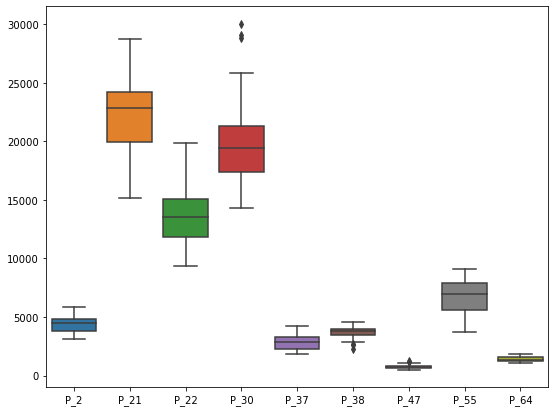

In [186]:
display(sales_s.describe().T.round(1))
plt.figure(figsize=(9,7))
sns.boxplot(data=sales_s)
plt.show()

Ce qu'on peut confimer graphiquement :

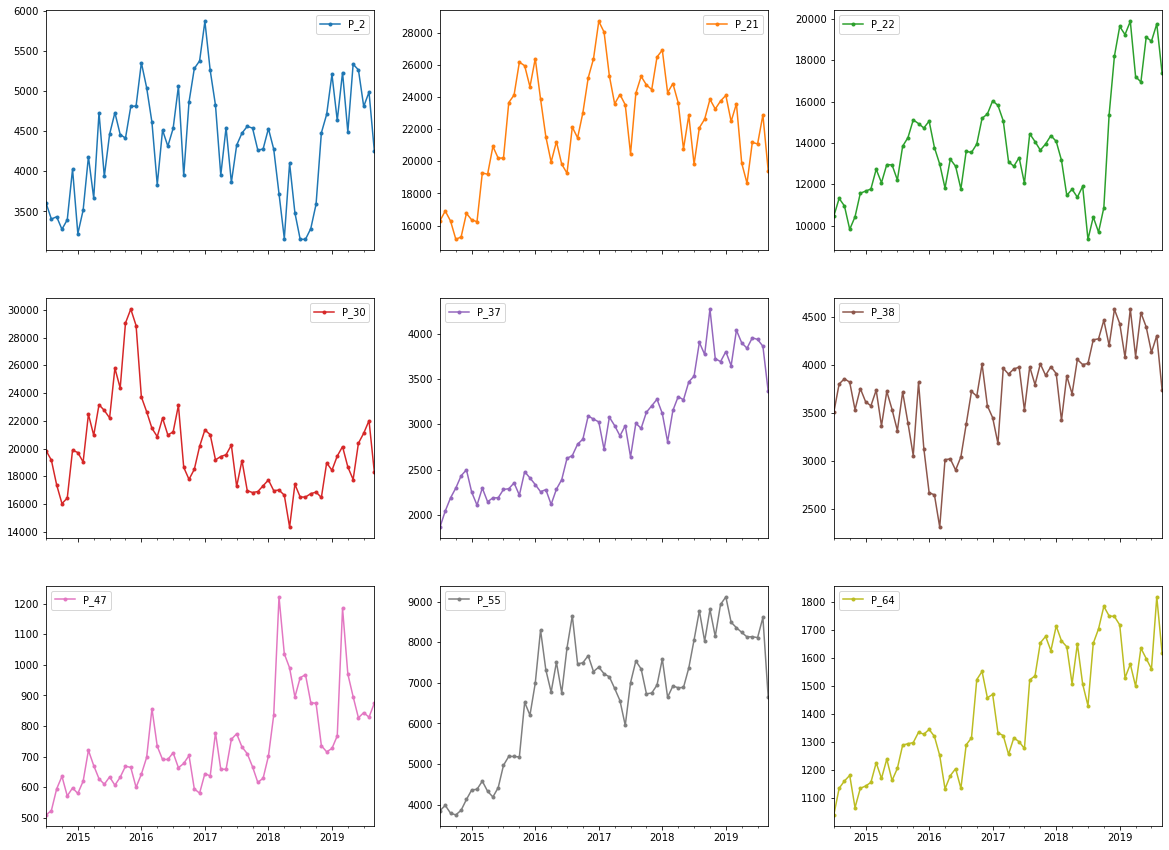

In [187]:
sales_s.plot(subplots=True,layout=(3,3),figsize=(20,15), marker='.')
plt.show()

## Moyenne mobile des séries

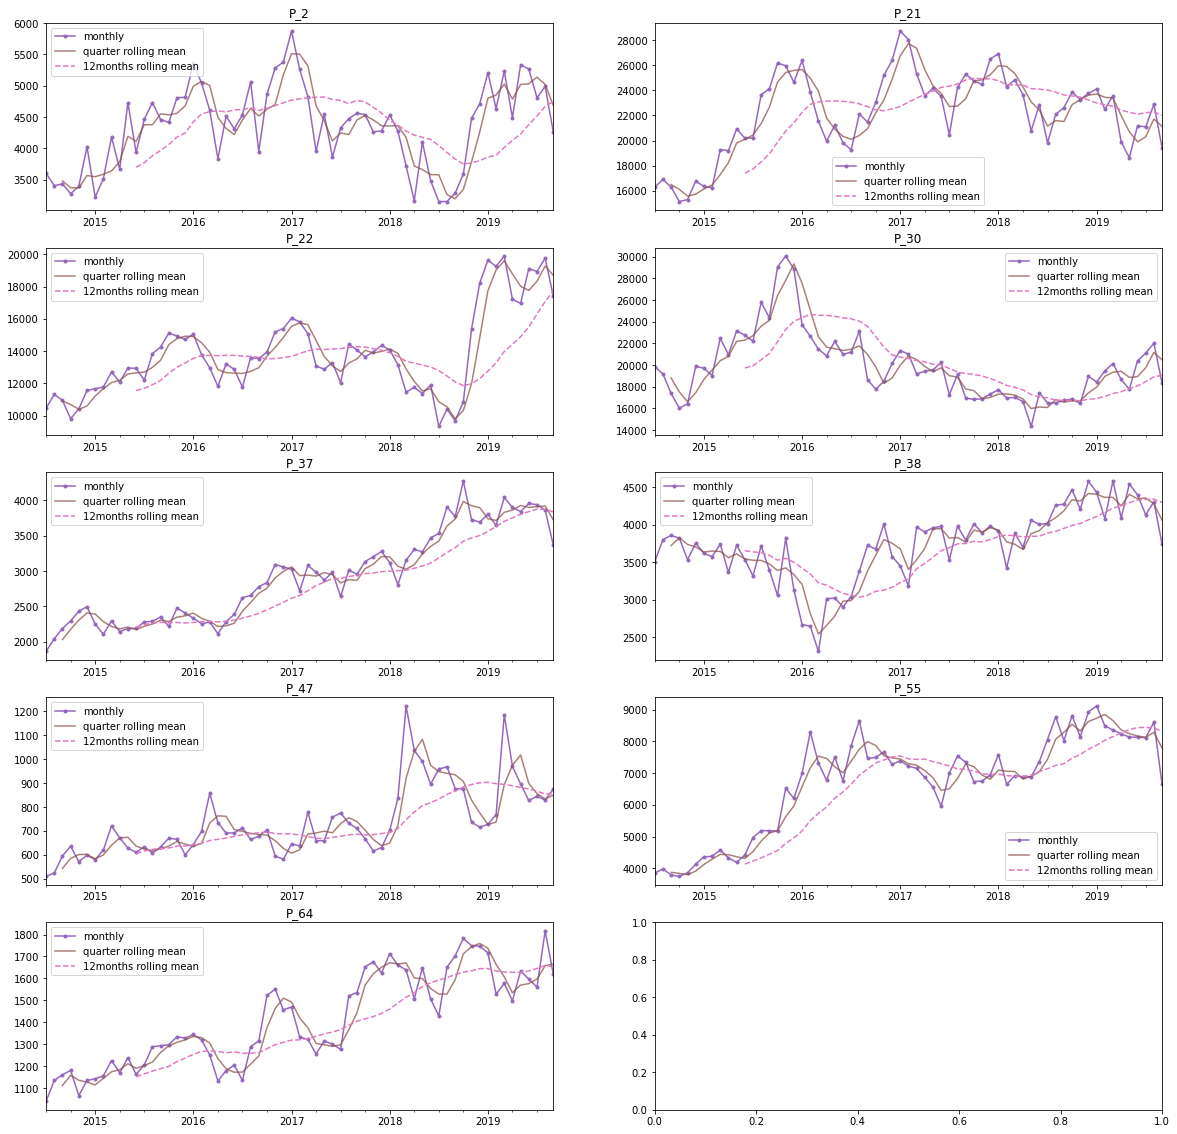

In [188]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20))
axs = axs.flatten()
cols = [next(color_cycle), next(color_cycle), next(color_cycle)]
for i, item in enumerate(sales_s.columns):
    sales_s[item].plot(title=item,
                     color=cols[0],
                     ax=axs[i],
                     marker='.', label="monthly")
    sales_s[item].rolling(3).mean().plot(
                     color=cols[1],
                     ax=axs[i], label="quarter rolling mean", alpha=0.75)
    sales_s[item].rolling(12).mean().plot(
                     color=cols[2],
                     ax=axs[i], linestyle='--', label="12months rolling mean")
    axs[i].legend()

## Décomposition des séries

In [189]:
def plotseasonal(res, axes, name):
    res.observed.plot(ax=axes[0], legend=False, title=name)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False, marker='o', linestyle='', markersize=5)
    axes[3].set_ylabel('Residual')
    plotseasonal.counter += 1
def grid_plotseasonal(df, ncol):
    nrow=ceil(len(df.columns)/ncol)*4
    fig, axes = plt.subplots(ncols=ncol, nrows=nrow, sharex=True, figsize=(15,1.5*nrow))
    plotseasonal.counter, k = 0, 0
    for i,col in enumerate(df.columns):
        res = seasonal_decompose(df[col].dropna(), period=12, filt=None)
        plotseasonal(res, axes[k:k+4, i%ncol], col)
        if (i%ncol)==(ncol-1) : k+=4
    plt.tight_layout()
    plt.show()

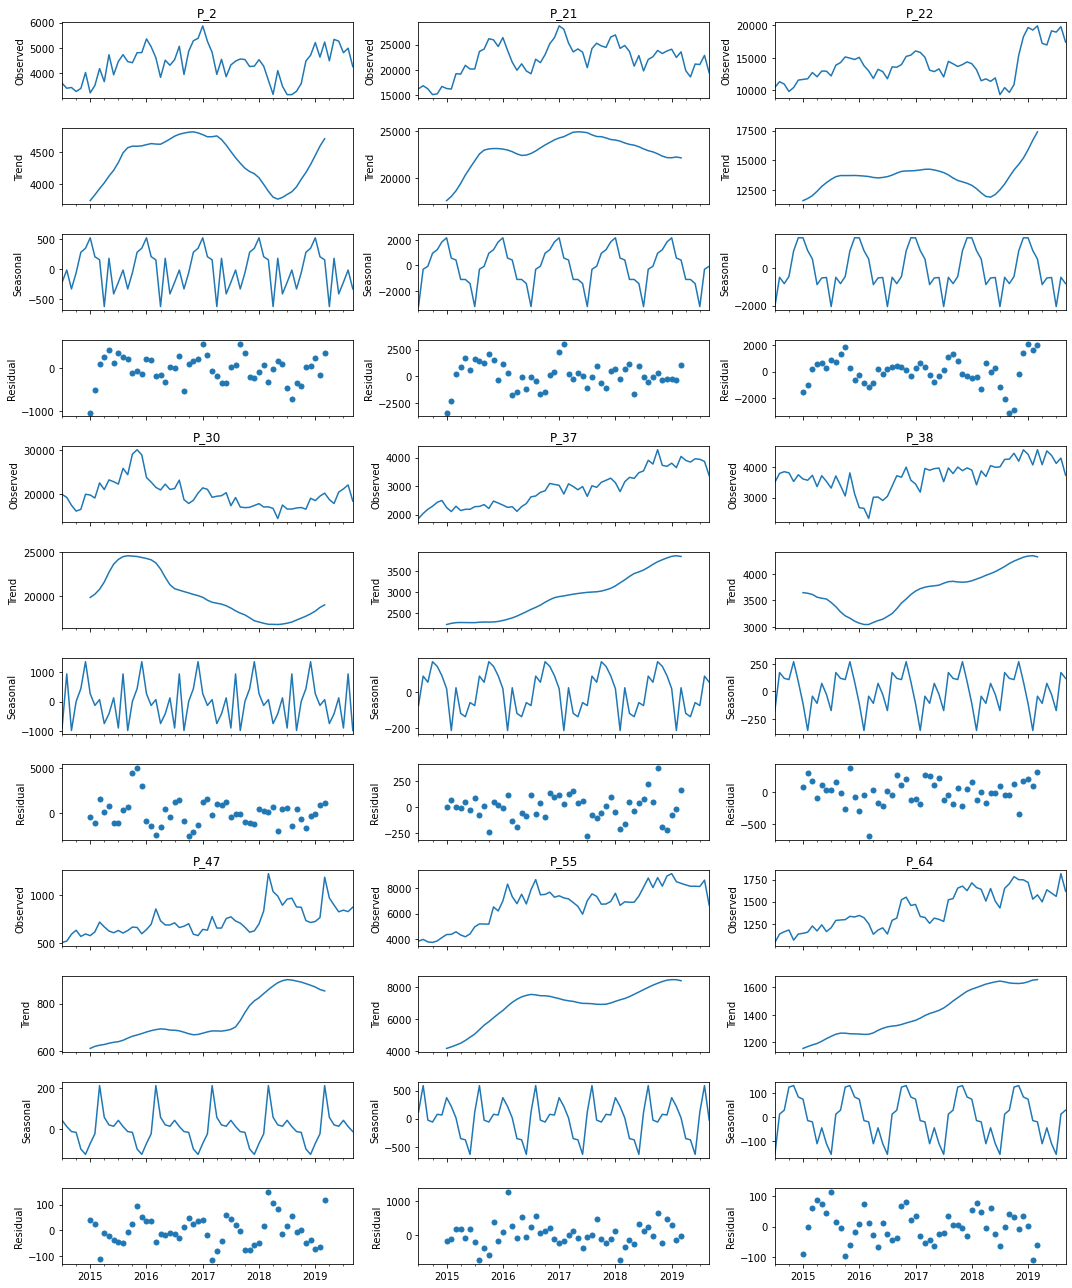

In [190]:
grid_plotseasonal(sales_s, ncol=3)

La fonction season_decompose peut être utilisée pour l'analyse des portions de chaque composant de la série chronologique. Ceci est particulièrement utile pour déterminer l'absorption des résidus dans les données, sur la base des données décomposées. Le volume de cette absorption implique la prévisibilité de la série chronologique - plus les résidus sont élevés, moins la prévisibilité. Dans une certaine mesure, la proportion des résidus par rapport à la tendance et à la saisonnalité peut également être illustrée par les graphiques des moyennes mobiles et des écarts-types ci-dessus.

In [191]:
d = pd.DataFrame(0, index=sales_s.columns, columns=["RESMEAN","OBSMEAN","PERC"], dtype=float)
for col in sales_s.columns:
    result = seasonal_decompose(sales_s[col], period=12, model='additive')
    res, obs = result.resid, result.observed
    d.loc[col][:2] = list(map(lambda x: np.mean(np.abs(x)), (res, obs[~np.isnan(res)])))
d.PERC = d.RESMEAN*100/d.OBSMEAN
d.round(2)

,RESMEAN,OBSMEAN,PERC
P_2,253.34,4376.67,5.79
P_21,912.88,23039.45,3.96
P_22,814.70,13678.31,5.96
P_30,1130.08,20098.61,5.62
P_37,94.88,2888.78,3.28
P_38,150.17,3677.69,4.08
P_47,46.05,738.08,6.24
P_55,261.75,6902.75,3.79
P_64,41.16,1418.96,2.90


Un diagramme de décalage (lag plot) est un nuage de points pour une série chronologique et les mêmes données décalées. Avec un tel graphe, nous pouvons vérifier s'il existe une corrélation possible entre les ventes ce mois et le mois précédent.

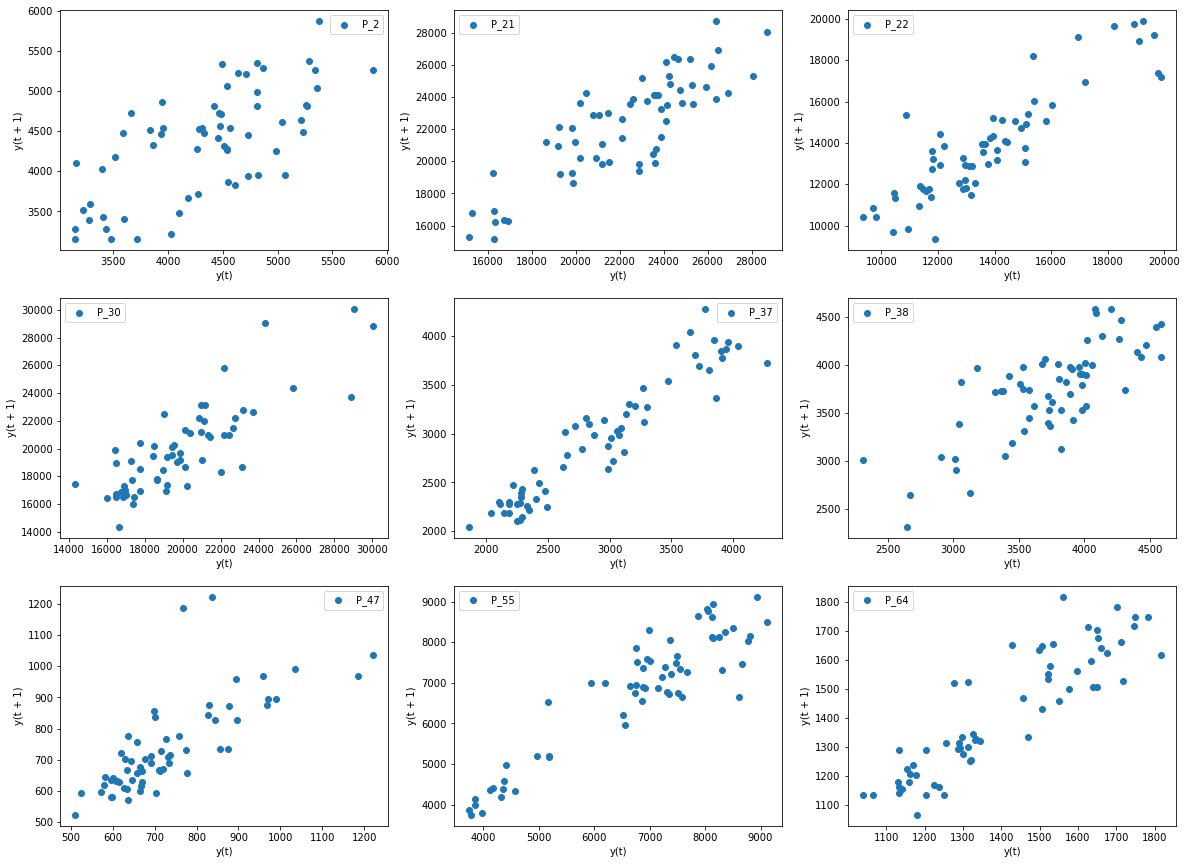

In [192]:
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.flatten()
for name, ax in zip(sales_s.columns, axes):
    lag_plot(sales_s[name], ax=ax, label=name)
    ax.legend()

In [193]:
sales_s.to_pickle("sales_s.pkl")